
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji, czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (ang.bias) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora, jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorowywać trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda lasso). 

Regresja grzebietowa i Lasso to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzebietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do :

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [26]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [27]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

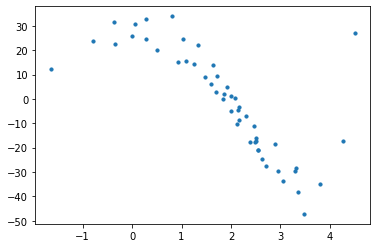

In [7]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_n x^n,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu C($\omega$) miała postać:

$$C_{ridge}(\omega)=\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [8]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(X, y, lamb, stopien_wielomianu):
    X = np.array([[np.power(i, j) for j in range(stopien_wielomianu+1)] for i in X])
    xTx = np.dot(X.T, X)
    ones = np.eye(stopien_wielomianu + 1)
    ones[0][0] = 0
    lamb_one = lamb*ones
    in_brackets = xTx + lamb_one
    inv_in_brackets = np.linalg.inv(in_brackets)
    big_xT = np.dot(inv_in_brackets, X.T)
    w = np.dot(big_xT, y)
    return w

w = regresja_L2(x,y, 0.01, 10)
w

array([ 2.81813084e+01, -3.58370151e-01, -7.16510094e+00,  1.26337110e+00,
        1.21411043e-01, -1.11634898e+00,  2.19288186e-01,  1.85169045e-01,
       -6.75785581e-02,  4.96918506e-03,  2.65697451e-04])

Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

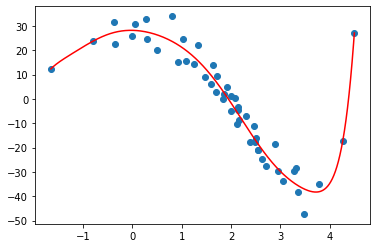

In [9]:
# Rysowanie wykresu 
plt.scatter(x, y)
x_lin = np.linspace(min(x), max(x), 400)
function = np.poly1d(w[::-1])
y_plot = np.array([function(x) for x in x_lin])
plt.plot(x_lin, y_plot, c='red')

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku nalezy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

In [10]:
# miejsce na kod
from sklearn.linear_model import Ridge

poly_degree = 10
X = np.array([[np.power(i, j) for j in range(poly_degree+1)] for i in x])
ridge_regression = Ridge(alpha = 0.01)
ridge_regression.fit(X, y)
print(f"Uzyskane współczynniki przy wykorzystaniu Ridge z sklearn: {ridge_regression.coef_}")

Uzyskane współczynniki przy wykorzystaniu Ridge z sklearn: [ 0.00000000e+00 -3.58368963e-01 -7.16510085e+00  1.26337138e+00
  1.21410371e-01 -1.11634866e+00  2.19288261e-01  1.85168927e-01
 -6.75785172e-02  4.96917881e-03  2.65697812e-04]


Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby byc zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostac podzielony na zbiór uczacy i testowy.

In [11]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

poly_degree = 15
X_train = np.array([[np.power(i, j) for j in range(poly_degree+1)] for i in X_train])
X_test = np.array([[np.power(i, j) for j in range(poly_degree+1)] for i in X_test])

Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [12]:
#Tworzę kolejne lambdy mnożąc przez 1.3
# Miejsce na potrzebne funkcje
def generate_lambs():
    lambs = [0.2]
    while max(lambs)*1.3 < 10:
        lambs.append(max(lambs)*1.3)
    lambs.append(10)
    return lambs
print(f"Lambdas: {generate_lambs()}")

Lambdas: [0.2, 0.26, 0.338, 0.43940000000000007, 0.5712200000000001, 0.7425860000000001, 0.9653618000000002, 1.2549703400000003, 1.6314614420000004, 2.1208998746000005, 2.7571698369800006, 3.584320788074001, 4.659617024496201, 6.057502131845062, 7.874752771398581, 10]


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

lambs = generate_lambs()
param_dict = {'alpha' : lambs}

cross_validation = GridSearchCV(Ridge(), param_dict, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True )
cross_validation.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.51938e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.39115e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.14478e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4985e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.95054e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.57519e-

C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.48596e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.5798e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.479e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.52691e-19): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80757e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.86606e-20

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.2, 0.26, 0.338, 0.43940000000000007,
                                   0.5712200000000001, 0.7425860000000001,
                                   0.9653618000000002, 1.2549703400000003,
                                   1.6314614420000004, 2.1208998746000005,
                                   2.7571698369800006, 3.584320788074001,
                                   4.659617024496201, 6.057502131845062,
                                   7.874752771398581, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)

In [14]:
results = cross_validation.cv_results_
# results

Text(0, 0.5, 'error')

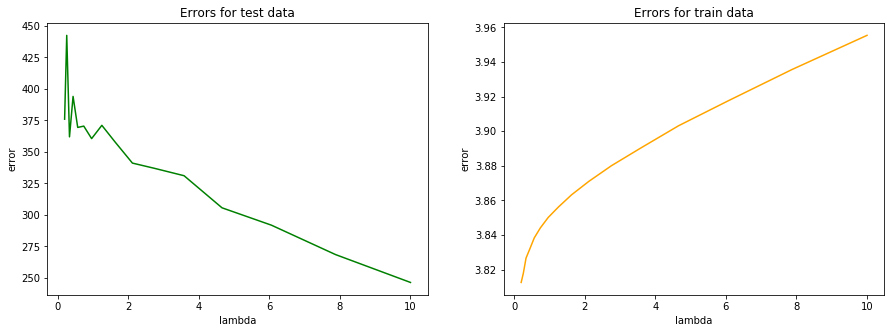

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(lambs, -1*results['mean_test_score'], color="green")
plt.title("Errors for test data")
plt.xlabel("lambda")
plt.ylabel("error")

plt.subplot(1,2,2)
plt.plot(lambs, -1*results['mean_train_score'], color="orange")
plt.title("Errors for train data")
plt.xlabel("lambda")
plt.ylabel("error")

**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

**1. Szybko spada błąd na zbiorze testowym, a bład na zbiorze uczącym rośnie (choć nieznacznie, nieporównywalnie wolniej niż spadek błędu testowego)**

**2. Jest to wartość 10**

In [16]:
cross_validation.best_params_['alpha']

10

Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\mbox{RMSE}=\sqrt{\frac{1}{k}\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

**Wybieram współczynnik 10, który okazał się najlepszy**

In [17]:
# Miejsce na potrzebne funkcje
best_model = Ridge(alpha=10)
best_model.fit(X_train, y_train)
result_best_model = best_model.predict(X_test)
print(f"Błąd dla wielomianu 15 stopnia to {mean_squared_error(y_test, result_best_model)}")

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
poly_degree = 5
X_train = np.array([[np.power(i, j) for j in range(poly_degree+1)] for i in X_train])
X_test = np.array([[np.power(i, j) for j in range(poly_degree+1)] for i in X_test])

best_model = Ridge(alpha=10)
best_model.fit(X_train, y_train)
result_best_model = best_model.predict(X_test)
print(f"Błąd dla wielomianu 5 stopnia to {mean_squared_error(y_test, result_best_model)}")

Błąd dla wielomianu 15 stopnia to 28.55447406424662
Błąd dla wielomianu 5 stopnia to 27.928376304175053


C:\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.64076e-20): result may not be accurate.
  overwrite_a=True).T


### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [30]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [31]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [32]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
X = sales.drop(["date", "price"], axis=1)
y = sales["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [33]:
# Miejsce na kod
from sklearn.linear_model import LinearRegression
import itertools
def best_features(how_many):
    
    features_set_error = {}
    lr = LinearRegression()
    features =  ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
    combinations = itertools.combinations(features, how_many)
    
    for combination in combinations:
        tmp_features = list(combination)
        errors = cross_val_score(lr, X_train[tmp_features], y_train, cv=5, scoring="neg_mean_squared_error")
        combination_error = np.sqrt(-1 * sum(errors)/len(tmp_features))
        features_set_error[combination_error] = tmp_features
        
    return features_set_error[sorted(features_set_error.keys())[0]], sorted(features_set_error.keys())[0]
# Wypisz zestawy cech najlepiej minimalizujące błąd CV dla różnej ilości cech. (Wyraz wolny pozostawiamy.)
for i in range(1,6):
    print(best_features(i))

(['sqft_living'], 582470.0556974057)
(['sqft_living', 'sqft_living_sqrt'], 393931.72802427964)


KeyboardInterrupt: 

Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [34]:
# Miejce na kod
def find_feature_greedy(how_many):
    lr = LinearRegression()
    features =  ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
    already_chosen = []
    for i in range(how_many):
        features_set_error = {}
        best_set = {}
        for feature in features:
            test_features = already_chosen + [feature]
            errors = cross_val_score(lr, X_train[test_features], y_train, cv=5, scoring="neg_root_mean_squared_error")
            combination_error = (-1 * sum(errors)/len(test_features))
            features_set_error[combination_error] = feature
         
        best_score = min(features_set_error.keys())
        already_chosen += [features_set_error[best_score]]
        best_set[best_score] = already_chosen
        features.remove(features_set_error[best_score])
    return best_set.values()
    
for i in range (1,6):
    print(find_feature_greedy(i))

dict_values([['sqft_living']])
dict_values([['sqft_living', 'sqft_living_sqrt']])
dict_values([['sqft_living', 'sqft_living_sqrt', 'grade']])
dict_values([['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']])
dict_values([['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront']])


**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

Wypadają niezwykle podobnie, wybierane są w większości te same cechy

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [28]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

In [29]:
for feature, coef in zip(all_features, model_all.coef_):
    if coef > 0:
        print(f"Cecha: {feature}, współczynnik: {coef}")

Cecha: sqft_living, współczynnik: 134.43931395541438
Cecha: view, współczynnik: 24750.004585609488
Cecha: grade, współczynnik: 61749.10309070811


**Zostały wybrane powyższe 3 cechy**

Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

Text(0, 0.5, 'error')

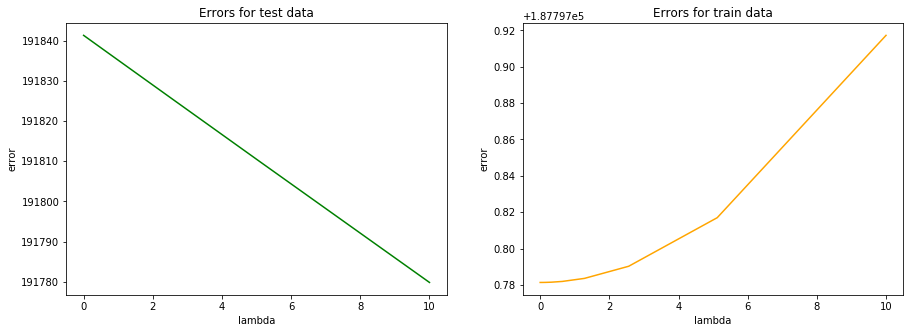

In [123]:
# Miejsce na kod
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

lambs = generate_lambs()
param_dict = {'alpha' : lambs}

cross_validation = GridSearchCV(linear_model.Lasso(), param_dict, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True )
cross_validation.fit(X_train, y_train)

results = cross_validation.cv_results_
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(lambs, -1*results['mean_test_score'], color="green")
plt.title("Errors for test data")
plt.xlabel("lambda")
plt.ylabel("error")

plt.subplot(1,2,2)
plt.plot(lambs, -1*results['mean_train_score'], color="orange")
plt.title("Errors for train data")
plt.xlabel("lambda")
plt.ylabel("error")

In [25]:
features_chosen = {}
for parameter, coef in zip(all_features, cross_validation.best_estimator_.coef_):
    if coef > 0:
        features_chosen[coef] = parameter
print("Współczynniki dla wybranych cech: \n", features_chosen)

plt.bar(features_chosen.values(), features_chosen.keys())
plt.xticks(rotation = 90)

NameError: name 'all_features' is not defined

**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [24]:
best = cross_validation.best_params_['alpha']
best

10

**1. Jak najwyższą -- nieznacznie podnosi ona błąd na zbiorze testowym, za to są widoczne różnice (błąd maleje) na zbiorze testowym**

**2. W kolejności od najbardziej do najmniej znaczącej, 4 cechy to: yr_built, sqft_lot_sqrt, waterfront, floors**